## Importing the Libraries


In [1]:
!pip install contractions
!pip install nltk


# Standard library imports
import string
import re

import contractions
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from wordcloud import WordCloud, STOPWORDS


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read in the Data

In [2]:
unclean_df = pd.read_csv("stock_data_text.csv")

## Analysing the Data

In [3]:
unclean_df.head(10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,-1
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


In [4]:
unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [5]:
unclean_df.describe()

,Sentiment
count,5791.000000
mean,0.272664
std,0.962192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Exploratory Data Analysis


Check for missing values

In [6]:
unclean_df.isna().sum().to_frame(name='Number of missing values')

,Number of missing values
Text,0
Sentiment,0


Check for and remove duplicate rows

In [7]:
before =  unclean_df.shape[0]
unclean_df.drop_duplicates(inplace=True)
after = unclean_df.shape[0]

print("No. of rows removed :", before - after)

No. of rows removed : 0


Remove HTML Syntaxes

In [8]:
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

In [9]:
unclean_df['Cleaned_Text'] = unclean_df['Text'].apply(lambda z: remove_html(z))


Remove URL Data

In [10]:
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data



In [11]:
unclean_df['Cleaned_Text'] = unclean_df['Text'].apply(lambda z: remove_url(z))


Remove any Emojis

In [12]:
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data



In [13]:
unclean_df['Cleaned_Text'] = unclean_df['Text'].apply(lambda z: remove_emoji(z))


Remove Contractions

In [14]:
unclean_df['Cleaned_Text'] = unclean_df['Cleaned_Text'].apply(contractions.fix)


Remove all punctuations



In [15]:
def remove_punctuation(text):
  return "".join([char for char in text if char not in string.punctuation])


unclean_df['Cleaned_Text'] = unclean_df['Cleaned_Text'].apply(remove_punctuation)

Lower Case

In [16]:
ticker_df = pd.read_csv('ticker_list1.csv')
ticker_df = ticker_df['Symbol']
ticker_df.head()

0        A
1       AA
2     AACG
3     AACI
4    AACIU
Name: Symbol, dtype: object

In [17]:
ticker_df2 = pd.read_csv('ticker_list2.csv')
ticker_df2 = ticker_df2['Symbol']
ticker_df2.head()

0        A
1       AA
2     AACG
3     AACI
4    AACIW
Name: Symbol, dtype: object

In [18]:
#Merge 2 series and convert it to a list
ticker_list1 = ticker_df.tolist()
ticker_list2 = ticker_df2.tolist()
all_tickers = list(set(ticker_list1 + ticker_list2))

In [19]:
def lowercase(text):
  word_list = text.split()
  return [word.lower() for word in text if word not in all_tickers]

Data has been cleaned, now we make a copy of it in a variable cleaned dataframe

In [20]:
cleaned_df = unclean_df

Tokenisation

In [21]:
tokenizer = TweetTokenizer()
cleaned_df['Cleaned_Text'] = cleaned_df['Cleaned_Text'].apply(tokenizer.tokenize)

Remove Stopwords

In [22]:
stop_words = set(stopwords.words('english'))


In [23]:
#Keep these words in the text as they could correlate to sentiment
keep_in_tokens = ["no","not", "on", "off", "too", "out", "over", "under"]

for word in keep_in_tokens:
    stop_words.remove(word)
def filter_tokens(tokens):
    return [token for token in tokens if token not in stop_words]
cleaned_df["Cleaned_Text"] = cleaned_df["Cleaned_Text"].apply(filter_tokens)


Lemmatisation


In [24]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

cleaned_df['Cleaned_Text'] = cleaned_df['Cleaned_Text'].apply(lemmatize_tokens)


### Comparing unprocessed vs processed text

In [25]:
cleaned_df.head(10)

,Text,Sentiment,Cleaned_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on watchlist XIDE TIT SOQ PNK CPW BPZ ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return FEAGEED indicator 15 ...
2,user I'd be afraid to short AMZN - they are lo...,1,user I would afraid short AMZN looking like ne...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
5,PGNX Over 3.04,1,PGNX Over 304
6,AAP - user if so then the current downtrend wi...,-1,AAP user current downtrend break Otherwise sho...
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1,Mondays relative weakness NYX WIN TIE TAP ICE ...
8,GOOG - ower trend line channel test & volume s...,1,GOOG ower trend line channel test volume support
9,AAP will watch tomorrow for ONG entry.,1,AAP watch tomorrow ONG entry


In [26]:
#Re-setting the cleaned_df to only a column with the cleaned text
temp_df = cleaned_df[['Cleaned_Text', 'Sentiment']].copy()
temp_df.rename(columns = {'Cleaned_Text': 'Text'}, inplace=True)
temp_df.head()

,Text,Sentiment
0,Kickers on watchlist XIDE TIT SOQ PNK CPW BPZ ...,1
1,user AAP MOVIE 55 return FEAGEED indicator 15 ...,1
2,user I would afraid short AMZN looking like ne...,1
3,MNTA Over 1200,1
4,OI Over 2137,1


In [27]:
cleaned_df = temp_df

## Word Cloud

In [28]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

Semantic 1 word cloud

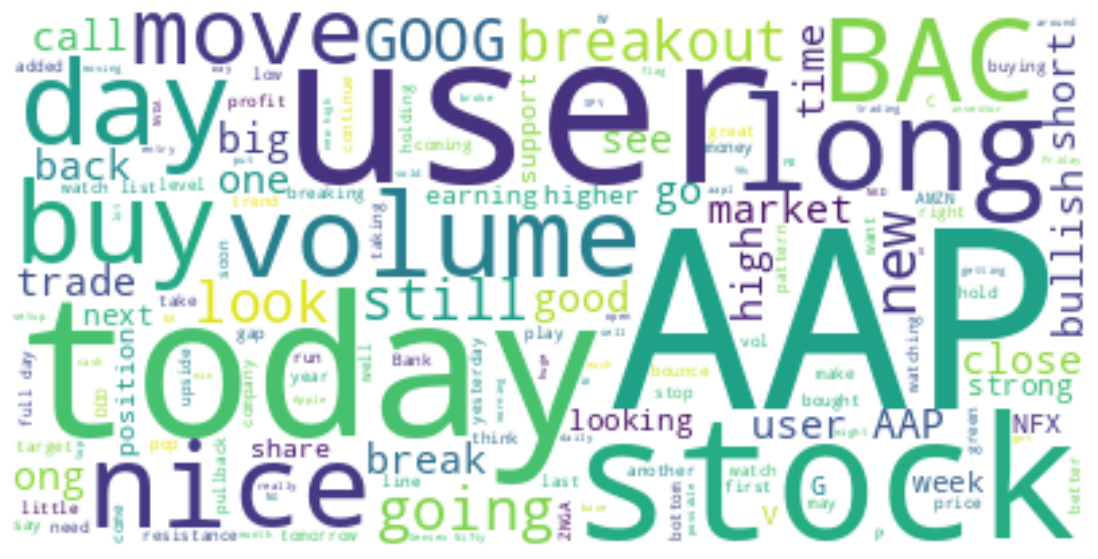

In [29]:
pos = cleaned_df.loc[cleaned_df['Sentiment'] == 1].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

Semantic -1 word cloud

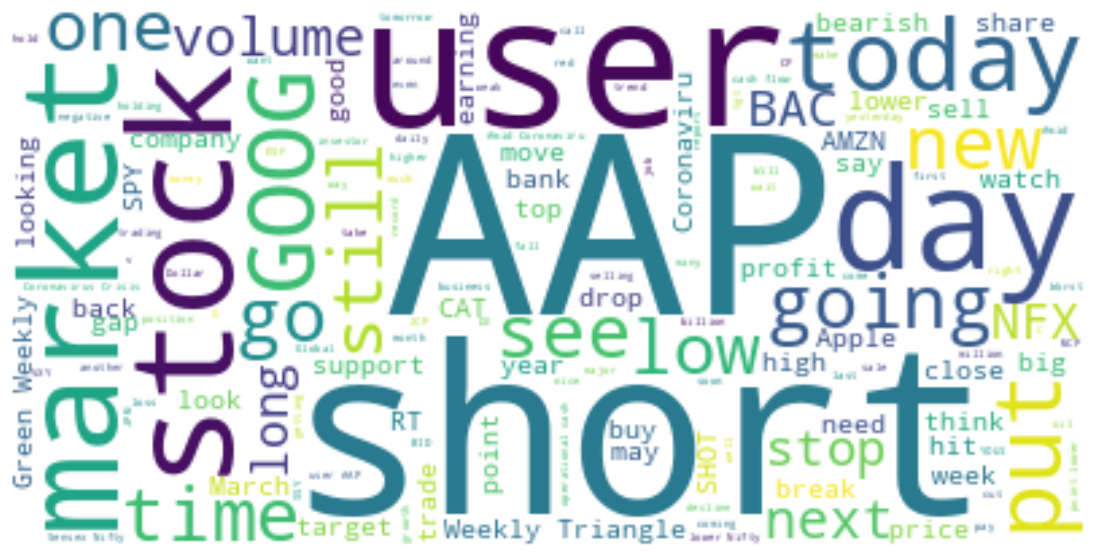

In [30]:
pos = cleaned_df.loc[cleaned_df['Sentiment'] == -1].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

## Train Test Split

Train data: 80%
Test data: 20%

In [31]:
X = cleaned_df['Text']
y = cleaned_df['Sentiment']

#Generate Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [32]:
X_train.shape, X_test.shape

((4632,), (1159,))

In [33]:
y_train.shape, y_test.shape

((4632,), (1159,))

## Vectorisation

Bag of Words Vectorizer

In [34]:
# Create a bag-of-words representation of the data
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(X_train)

# Transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

TF_IDF Vectorizer

In [35]:
# Create a term frequency representation of the data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

## Testing out different Models  

In [36]:
from sklearn.metrics import accuracy_score

#Create standardised function to train and evaluate a particular model
def train_and_eval(model, trainX, trainY, testX, testY):

    # training the model
    fitted_model = model.fit(trainX, trainY)

    # getting predictions
    y_preds_train = fitted_model.predict(trainX)
    y_preds_test = fitted_model.predict(testX)

    # evaluating the model
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

Logistic Regression with BoW Vectorizer

In [37]:
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500)
Train accuracy score : 0.6338514680483592
Test accuracy score : 0.6462467644521139

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500)
Train accuracy score : 0.6951640759930915
Test accuracy score : 0.6919758412424504

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500)
Train accuracy score : 0.8404576856649395
Test accuracy score : 0.7566867989646247

 ----------------------------------------

LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.9669689119170984
Test accuracy score : 0.7748058671268335

 ----------------------------------------

LogisticRegression(C=10, max_iter=500)
Train accuracy score : 0.9976252158894646
Test accuracy score : 0.7799827437446074

 ----------------------------------------


Naive Bayes Classifier with BoW Vectorizer

In [38]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9639464594127807
Test accuracy score : 0.7377049180327869

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9479706390328152
Test accuracy score : 0.7644521138912856

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.9246545768566494
Test accuracy score : 0.7722174288179465

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9164507772020726
Test accuracy score : 0.7722174288179465

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9073834196891192
Test accuracy score : 0.7713546160483176

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Random Forest Classifier with BoW Vectorizer

In [39]:
trees = [100,130,150,170,200]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


RandomForestClassifier()
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7842968075927523

 ----------------------------------------

RandomForestClassifier(n_estimators=130)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7877480586712683

 ----------------------------------------

RandomForestClassifier(n_estimators=150)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7842968075927523

 ----------------------------------------

RandomForestClassifier(n_estimators=170)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7817083692838654

 ----------------------------------------

RandomForestClassifier(n_estimators=200)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7868852459016393

 ----------------------------------------


Logistic Regression with TFIDF Vectorizer

In [40]:
C = [0.001, 0.01, 0.1, 1, 10,]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500)
Train accuracy score : 0.6338514680483592
Test accuracy score : 0.6462467644521139

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500)
Train accuracy score : 0.6338514680483592
Test accuracy score : 0.6462467644521139

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500)
Train accuracy score : 0.6690414507772021
Test accuracy score : 0.6660914581535806

 ----------------------------------------

LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.8711139896373057
Test accuracy score : 0.7739430543572045

 ----------------------------------------

LogisticRegression(C=10, max_iter=500)
Train accuracy score : 0.9885578583765112
Test accuracy score : 0.7825711820534944

 ----------------------------------------


Naive Bayes Classifier with TFIDF Vectorizer

In [41]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9665371329879102
Test accuracy score : 0.7420189818809318

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9419257340241797
Test accuracy score : 0.7523727351164797

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.8916234887737479
Test accuracy score : 0.7489214840379638

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.8678756476683938
Test accuracy score : 0.7437446074201898

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.8480138169257341
Test accuracy score : 0.7377049180327869

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Random Forest Classifier with TFIDF Vectorizer

In [42]:
trees = [100,130,150,170,200]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


RandomForestClassifier()
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7635893011216566

 ----------------------------------------

RandomForestClassifier(n_estimators=130)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7627264883520276

 ----------------------------------------

RandomForestClassifier(n_estimators=150)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7670405522001725

 ----------------------------------------

RandomForestClassifier(n_estimators=170)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7661777394305436

 ----------------------------------------

RandomForestClassifier(n_estimators=200)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7627264883520276

 ----------------------------------------


## Best Model

Comparing the results above, Random Forest Classifier with BoW data performs the best on test data

In [43]:
RandFor = RandomForestClassifier(n_estimators = 130)
train_and_eval(model=RandFor,
                  trainX=bow_X_train,
                  trainY=y_train,
                  testX=bow_X_test,
                  testY=y_test)


RandomForestClassifier(n_estimators=130)
Train accuracy score : 0.9997841105354058
Test accuracy score : 0.7834339948231234

 ----------------------------------------
